# **1. Forecasting urban floods**

*pitched by Samuel Barsanelli Costa | Data Science **batch #1643***

## **1.1. Problem statement**

What is an urban flood and why should we care about forecasting it?

📽️ A picture is worth a thousand words...

<iframe width="600" height="339"
src="https://www.youtube.com/embed/qefFjVbrZwE?autoplay=1&mute=1">
</iframe>

This is a global issue related to climate change, as raised by the [UN](https://www.undrr.org/)'s [GAR23](https://www.undrr.org/gar/gar2023-special-report) report:
* the increase in the intensity of rainfall is already increasing flood risk 🌧️
* flood damage shall increase by **170%** with a global **2°C warming** 🔥

Additional regional conditions may intensify this effects, such as the El Niño that triggered [unprecedented flooding in the southern Brazilian state of Rio Grande do Sul](https://wmo.int/media/news/el-nino-linked-rains-trigger-devastation-brazil).

🌎 With the best **think globally, act locally** spirit in mind, this idea is scoped to predict flood in (yet to be defined) one among the most affected cities at the Porto Alegre Metro Area during the flooding events of April and May 2024

From a data science perpective, flood prediction is not new. The [Journal of Hydrology](https://www.sciencedirect.com/journal/journal-of-hydrology) alone has over 5k publications about it over the last 20 years.

Even Google has it's own AI model to predict daily flood. They've published their approach on a [paper](https://www.nature.com/articles/s41586-024-07145-1) in Nature, and made it online at the [Flood Hub](https://sites.research.google/floods/l/0/0/3) in 80+ countries.

![https://sites.research.google/floods/](google_flood_hub.jpg)

But all resources available about flooding are way too much technical, not suited for the mainstream.

Could anyone quickly disgest this [data plot](https://app.powerbi.com/view?r=eyJrIjoiZTRjZDlmYjgtNzAzMS00ZTFmLTlmZDAtNzEwNjM0MDU0NTJhIiwidCI6ImUwYmI0MDEyLTgxMGItNDY5YS04YjRkLTY2N2ZjZDFiYWY4OCJ9) and make an informed "fight-or-flight" decision? 🤔

![https://app.powerbi.com/view?r=eyJrIjoiZTRjZDlmYjgtNzAzMS00ZTFmLTlmZDAtNzEwNjM0MDU0NTJhIiwidCI6ImUwYmI0MDEyLTgxMGItNDY5YS04YjRkLTY2N2ZjZDFiYWY4OCJ9](guaiba_telemetry.jpg)

The driving questions of this idea are:
* can a classification model be trained to predict flood from rainfall data?
* how accurate could it be?
* how for in advance could we predict a flood (e.g. 5-day)?
* could we publish it in real-time in a easy-to-digest fashion?
* does it make sense to communicate just as we do with weather forecast?

💪 Let's work together for it!
![What if the flood forecast was like this?](the_flood_forecast.jpg)

## **1.2. Viability analysis**

 To address this model we'll need, at least:

* **river stage data**: the measure of how high the level of the river is, at a certain location, in reference to a ground level (usually measured in cm). This is the target variable, the ```y``` 🎯
* **historical rainfall data**: the amount of rainfall at a certain location, measured as the amont of rainfall in a squared meter and reported as water height of that square (in mm). This is the exogenous variable, what [Darts](https://unit8co.github.io/darts/userguide/covariates.html) defines as ```past covariates```.
* **future rainfall data**: this should be a reliable rainfall forecast source, in the same format as the historical data (measuring unit and sampling rate). This is what Darts defines as ```future covariates```.

Automated Telemetry Stations comes out to the the best source for this goal, as it continuosly collect data at a certain timeframe (usually between 15 min and 60 min) and is less prone to human data collection errors.

One important thing to note is that rainfall is a spatially distributed fenomenon, so we should avoid relling on a single point-source for rain data. The area where all the water comes down to one single point is called watershed or [drainage basin](https://en.wikipedia.org/wiki/Drainage_basin). Note that it might not be raining at the very location of a flood, but all rain the poured down up in the mountains will flow over eventually and hit the lowest point. So the more rainfall stations we collect data from, within the drainage are, the best!

<html>
<head>
<style>
img {
  width: 100%;
}
</style>
</head>
<body>

<img src="https://elbowlakecentre.ca/wp-content/uploads/2023/11/Picture1-4.png.webp" alt="https://elbowlakecentre.ca/wp-content/uploads/2023/11/Picture1-4.png.webp" style="width:600px;">

</body>
</html>


### **1.2.1. Data sources**

Here's the avaiable data from Automated Telemetry Stations and a reliable source for rainfall forecast.

| Data            | Source      | Format | Measuring unit | Sampling rate | Time span   | URL                                         |
|-----------------|-------------|--------|----------------|---------------|-------------|---------------------------------------------|
| River stage     | SEMA/RS     | xls    | cm             | 15 min        | 2014 on     | https://saladesituacao.rs.gov.br/dados      |
| Past rainfall   | SEMA/RS     | xls    | mm             | 15 min        | 2014 on     | https://saladesituacao.rs.gov.br/dados      |
|  └──────        | INMET       | csv    | mm             | 1 hour        | 2000 on     | https://portal.inmet.gov.br/dadoshistoricos |
| Future rainfall | OpenWeather | API    | mm             | 3 hours       | next 5 days | https://openweathermap.org/forecast5        |

📈 And here's a quick plot of a subset of the river stage and rainfall data from [São Leopoldo/RS station](https://saladesituacao.rs.gov.br/api/station/ana/sheet/87382000) at the Sinos River:
* **6 months** of 15-min data collection, from January 15th 2024 up to July 15h 2024
* One historical flooding event registered (May 4th 2024)
* A total of **17.215 data samples**

In [79]:
import pandas as pd
import requests
import io

# Get SEMA data from Sao Leopoldo station
response = requests.get('https://saladesituacao.rs.gov.br/api/station/ana/sheet/87382000')

# Convert the binary response to an excel file and pass it to a dataframe
with io.BytesIO(response.content) as excel_file:
    df = pd.io.excel.read_excel(
        excel_file,
        skiprows = 8,
        names = ['date', 'stage', 'discharge', 'rainfall'],
        dtype = {'date': object, 'stage': float, 'discharge': float, 'rainfall': float}
    )

# Drop discharge column
df = df.drop(columns='discharge')

# Parse date and set it as index
df.index = pd.to_datetime(df.date, format='%d/%m/%Y %H:%M:%S', )
df.index.name = None
df.drop(columns='date', inplace=True)

# Preview the source
df

,stage,rainfall
2024-07-19 21:15:00,341.0,0.0
2024-07-19 21:00:00,341.0,0.0
2024-07-19 20:45:00,341.0,0.0
2024-07-19 20:30:00,341.0,0.0
2024-07-19 20:15:00,341.0,0.0
...,...,...
2018-08-01 14:15:00,357.0,0.0
2018-08-01 14:00:00,357.0,0.0
2018-08-01 13:45:00,357.0,0.0
2018-08-01 13:30:00,358.0,0.0


In [80]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

# Slice the dataframe for the plot (uncomment if needed)
start_date = '2024-01-15'
# end_date = '2024-07-15'
df_slice = df.loc[start_date:]

# Interpolate NaN values (uncomment if needed)
# df_slice.stage.interpolate(method='linear', inplace=True)
# df_slice.rainfall.interpolate(method='linear', inplace=True)

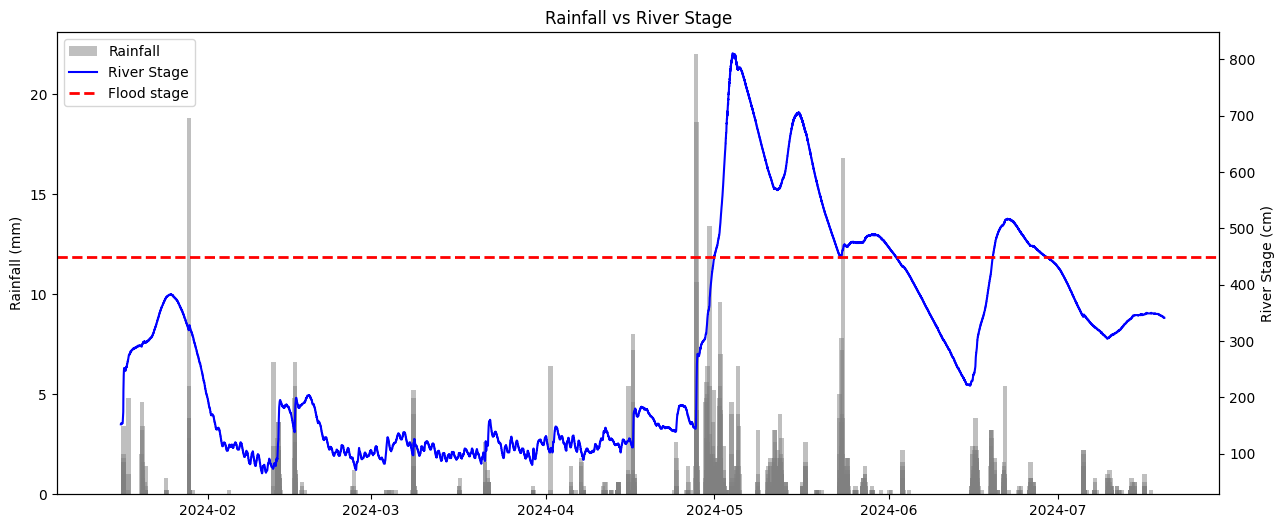

In [81]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot rainfall on the primary y-axis
ax1.bar(df_slice.index, df_slice.rainfall, color='gray', alpha=0.5, label='Rainfall')
ax1.set_ylabel('Rainfall (mm)')
ax1.tick_params(axis='y')

# Create a secondary y-axis for stage
ax2 = ax1.twinx()
ax2.plot(df_slice.index, df_slice.stage, color='blue', label='River Stage')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('River Stage (cm)')
ax2.tick_params(axis='y')

# Add reference lines (uncomment if needed)
ax2.axhline(y=450, color='red', linestyle='--', linewidth=2, label='Flood stage')
# plt.axvline(dt.datetime(2024, 4, 27, hour=12), color='black', linestyle='--', label='Stage rise')
# plt.axvline(dt.datetime(2024, 5, 4, hour=12), color='black', linestyle='-.', label='Stage peak')

# Add legends
lines, labels = ax1.get_legend_handles_labels()
bars, bar_labels = ax2.get_legend_handles_labels()
ax1.legend(lines + bars, labels + bar_labels, loc='upper left')

# Show the plot
plt.title('Rainfall vs River Stage')
plt.show()

😮 It gets even more impressive when we accumulate rainfall over a moving window of 11 days (the time it takes for a raindrop from up top in the mountain to get all the way down to the flooding area).

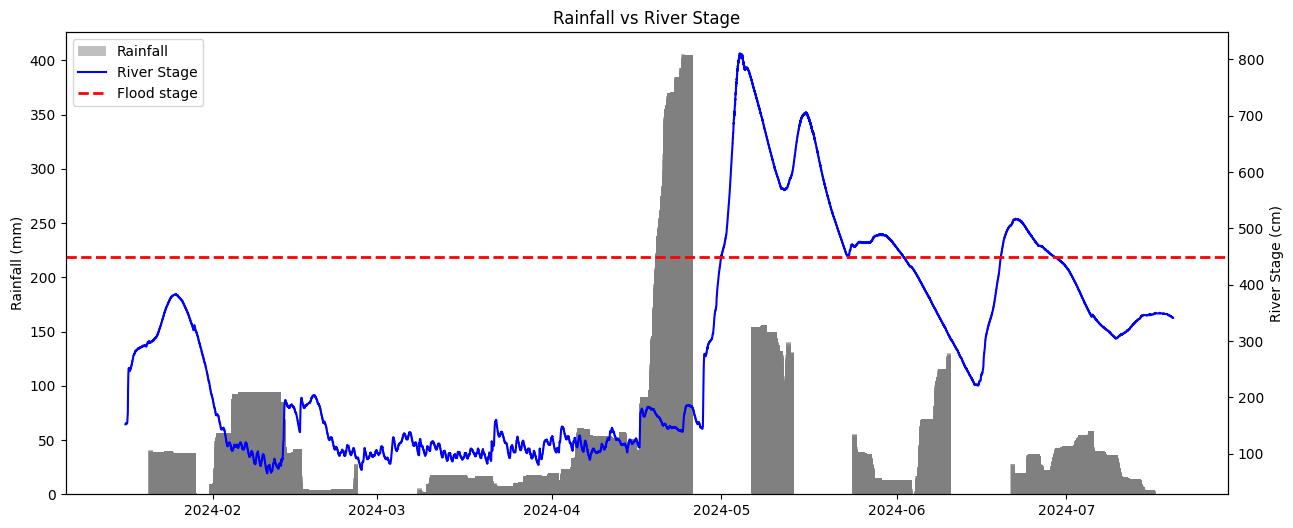

In [82]:
# Accumulated rainfall
## Get the amount of samples to be accumulated
peak_time = dt.datetime(2024, 5, 4, hour=12) - dt.datetime(2024, 4, 27, hour=12)
concentration_time = (peak_time / 0.6).days
concentration_time_samples = concentration_time * 24 * 4    # one sample every 15 min

## Add it to a new column in the df
temp = np.convolve(df_slice.rainfall, np.ones(concentration_time_samples))
df_slice['accum_rainfall'] = temp[:df_slice.shape[0]]

# Create a new plot
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot rainfall on the primary y-axis
ax1.bar(df_slice.index, df_slice.accum_rainfall, color='gray', alpha=0.5, label='Rainfall')
ax1.set_ylabel('Rainfall (mm)')
ax1.tick_params(axis='y')

# Create a secondary y-axis for stage
ax2 = ax1.twinx()
ax2.plot(df_slice.index, df_slice.stage, color='blue', label='River Stage')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('River Stage (cm)')
ax2.tick_params(axis='y')

# Add reference lines
ax2.axhline(y=450, color='red', linestyle='--', linewidth=2, label='Flood stage')

# Add legends
lines, labels = ax1.get_legend_handles_labels()
bars, bar_labels = ax2.get_legend_handles_labels()
ax1.legend(lines + bars, labels + bar_labels, loc='upper left')

# Show the plot
plt.title('Rainfall vs River Stage')
plt.show()

# **2. HTML Setup**

From here on the cells are ommited from the html-slide

In [83]:
# Run this cell to save the notebook before generating slides
from IPython.display import Javascript, display
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

In [86]:
# Run this cell to generate slides and hit stop to kill the server
!jupyter nbconvert index.ipynb --to slides --post serve --no-prompt \
--TagRemovePreprocessor.remove_input_tags=remove_input \
--TagRemovePreprocessor.remove_all_outputs_tags=remove_output

[NbConvertApp] Converting notebook index.ipynb to slides
[NbConvertApp] Writing 756826 bytes to index.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/index.slides.html
Use Control-C to stop this server
404 GET /favicon.ico (127.0.0.1) 0.51ms
^C

Interrupted


In [ ]:
# Run this cell to rename the *.slides.hmtl and push it to the host
import os
os.rename('index.slides.html', 'index.html')

!git add index.html
!git commit -m 'updated index.html'
!git push origin main

[main e3d966e] updated index.html
 1 file changed, 4 insertions(+), 4 deletions(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 8 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 393 bytes | 393.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To github.com:samuelbarsanellicosta/data-flood-forecasting-pitch.git
   80ff18f..e3d966e  main -> main


Wait a few minutes after the push to broadcast the updates in the repo and hit the link!

👉 [Link to the published html-slide](https://samuelbarsanellicosta.github.io/data-flood-forecasting-pitch/)

<details>
    <summary><i>💡 Learn more about generating a html-slide version of the notebook</i></summary>

In VSCode, right-click on the cell and:
- Click on `Switch Slide Type` to set the proper configuration for the cell
- Click on `Add Cell Tag` to add tags if needed

Then, generate an html-slide version of this using the following command:

```
jupyter nbconvert index.ipynb --to slides --post serve --no-prompt \
--TagRemovePreprocessor.remove_input_tags=remove_input \
--TagRemovePreprocessor.remove_all_outputs_tags=remove_output
```

- `no-prompt` removes the In [xx]: and Out[xx]: to the left of each cells
- `--TagRemovePreprocessor` allows you to not display either inputs or outputs of cells that have the associated Tag

As for hosting the html using GitHub, pages change the ```<output-format>``` like this:

``` jupyter nbconvert --to html index.ipynb ```

Make sure to name the notebook as 'index' and that GitHub Pages [settings](https://pages.github.com/) are properly set.

</details>